# Assignment 4 – Lineaarinen regressio, Korrelaatio ja Ominaisuuksien valinta

Auto MPG -aineisto

**Ryhmän jäsenet:**
Anniina Mäkinen, Jyri Männikkö, Niina Pietilä

**Vastuut:**
Valitsimme yhdessä datasetin tehtävälle. Tutustuimme yhdessä tehtävänantoon ja pyrimme kommentoimaan koodia tukeaksemme mahdollisimman paljon omaa oppimistamme. 

**Niina** - Päälineaarisen regressiomallin ohjelmointi, ominaisuustekniikka ja malliyhdistelmien arviointi

**Jyri** - Datan esikäsittely, aputoimintojen toteutus, alustavat visualisoinnit ja mallivalintojen avustus.

**Anniina** - Tulosten tulkinta, visualisointi ja raportointi, valitun mallin suorituskyvyn selitys ja havainnot

## Datasettin kirjastot ja datan luku

### Datasetti - Auto MPG

Tutkimme autojen polttoaineenkulutusta lineaarisen regression avulla, sekä harjoittelemme korrelaation tulkintaa ja ominaisuuksien -valintaa.

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

df = pd.read_csv("autoMPG.csv")

df.head()

,GallonsPer100Miles,GallonsPer100MilesTo1981,MPG,Cylinders,Displacement100ci,Horsepower100,Weight1000lb,Seconds0to60,Year,Year70To81,Origin,Origin.Eq.1,Origin.Eq.2,Origin.Eq.3,Name
0,"5,6","5,6",18,8,"3,07","1,3","3,504",12,70,1,1,1,0,0,chevrolet chevelle malibu
1,"6,7","6,7",15,8,"3,5","1,65","3,693","11,5",70,1,1,1,0,0,buick skylark 320
2,"5,6","5,6",18,8,"3,18","1,5","3,436",11,70,1,1,1,0,0,plymouth satellite
3,"6,3","6,3",16,8,"3,04","1,5","3,433",12,70,1,1,1,0,0,amc rebel sst
4,"5,9","5,9",17,8,"3,02","1,4","3,449","10,5",70,1,1,1,0,0,ford torino


Puuttuvien arvojen käsittely sekä muuttujien muutos "float" muotoon.

In [223]:
comma_cols = [
    "GallonsPer100Miles",
    "GallonsPer100MilesTo1981",
    "MPG",
    "Displacement100ci",
    "Horsepower100",
    "Weight1000lb",
    "Seconds0to60",
]

for col in comma_cols:
    df[col] = df[col].str.replace(",", ".").astype(float)


df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 361
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GallonsPer100Miles        362 non-null    float64
 1   GallonsPer100MilesTo1981  362 non-null    float64
 2   MPG                       362 non-null    float64
 3   Cylinders                 362 non-null    int64  
 4   Displacement100ci         362 non-null    float64
 5   Horsepower100             362 non-null    float64
 6   Weight1000lb              362 non-null    float64
 7   Seconds0to60              362 non-null    float64
 8   Year                      362 non-null    int64  
 9   Year70To81                362 non-null    int64  
 10  Origin                    362 non-null    int64  
 11  Origin.Eq.1               362 non-null    int64  
 12  Origin.Eq.2               362 non-null    int64  
 13  Origin.Eq.3               362 non-null    int64  
 14  Name           

## Part 1

### 1.1 Muuttujien peruskuvaus

In [224]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GallonsPer100Miles,362.0,4.916022,1.663147,2.100,3.600,4.7000,6.050,11.10
GallonsPer100MilesTo1981,362.0,4.916022,1.663147,2.100,3.600,4.7000,6.050,11.10
MPG,362.0,22.737017,7.562831,9.000,16.600,21.5000,28.000,46.60
Cylinders,362.0,5.577348,1.725107,3.000,4.000,6.0000,8.000,8.00
Displacement100ci,362.0,1.999047,1.064790,0.680,1.050,1.5600,3.020,4.55
Horsepower100,362.0,1.063757,0.392794,0.460,0.760,0.9500,1.315,2.30
Weight1000lb,362.0,3.022619,0.863368,1.613,2.237,2.9025,3.672,5.14
Seconds0to60,362.0,15.461050,2.772901,8.000,13.500,15.4000,17.000,24.80
Year,362.0,75.480663,3.381703,70.000,73.000,76.0000,78.000,81.00
Year70To81,362.0,1.000000,0.000000,1.000,1.000,1.0000,1.000,1.00


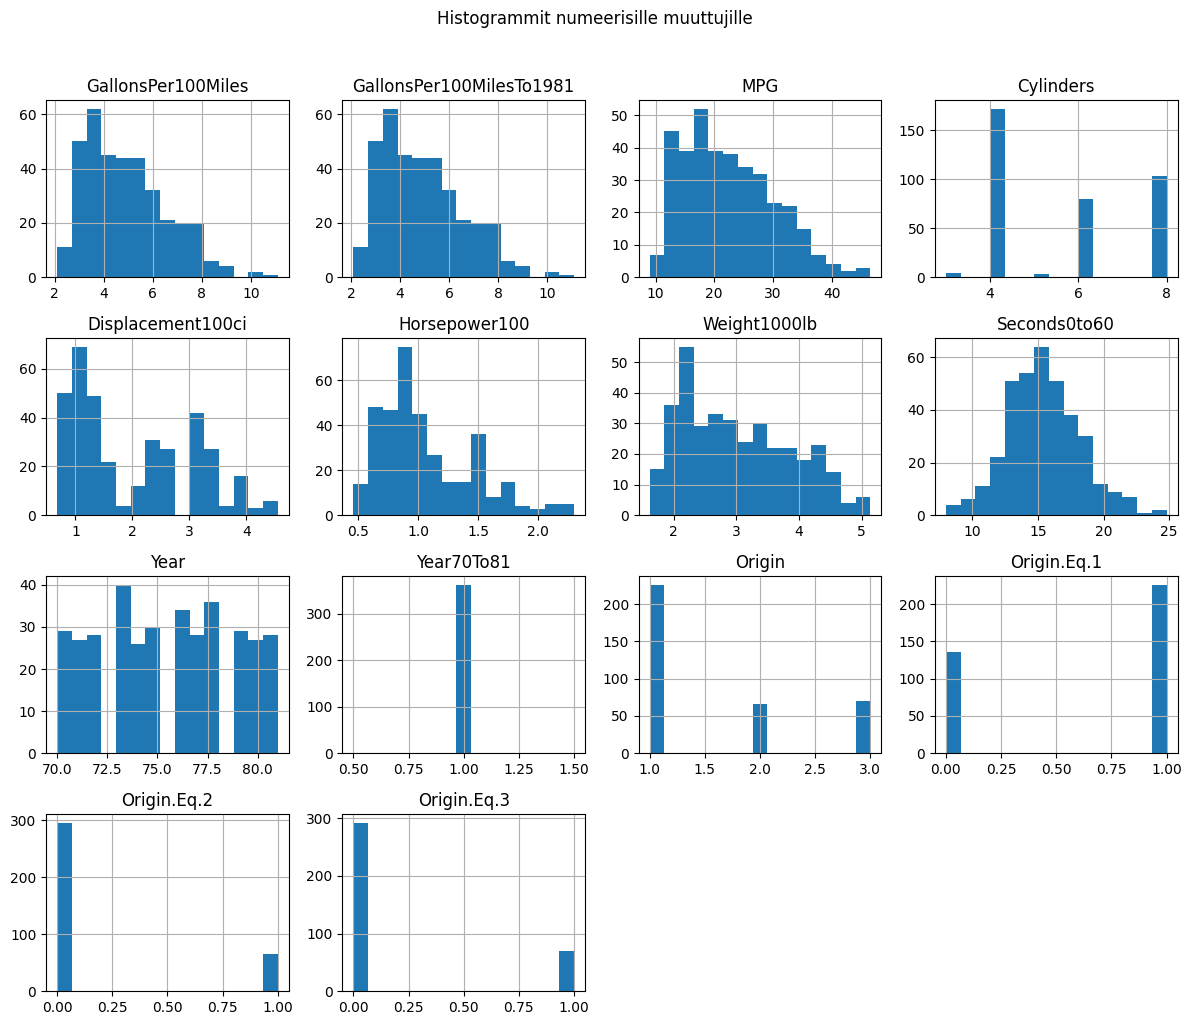

In [225]:
df.hist(figsize=(12, 10), bins=15)
plt.suptitle("Histogrammit numeerisille muuttujille", y=1.02)
plt.tight_layout()
plt.show()

**Tuloksien tulkinta**

- Useimmissa muuttujissa on tarpeeksi vaihtelua regressiota varten, eikä muuttujat ole liian tasaisia
    - Esimerkiksi autojen kulutus vaihtelee melko laajalla alueella, mikä on hyvä asia regressiota varten
- Paino, iskutilavuus ja teho näyttävät olevan vahvasti oikeaan vinossa, jolloinka suuria arvoja on vähemmän
- Kulutukseen liittyvät muuttujat käyttäytyvät loogisesti: mitä enemmän maileja per gallon sitä vähemmän gallonia per 100 mailia

### 1.2 Yksinkertainen lineaarinen regressiomalli

In [226]:
X = df[["Weight1000lb"]]
y = df["GallonsPer100Miles"]

In [227]:
#Jako opetus- ja testijoukkooihin

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

#EKulutuksen ennustus
y_pred = lin_model.predict(X_test)

# R2 ja MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Intercept:", lin_model.intercept_)
print("Weight1000lb:", lin_model.coef_[0])
print("Test R²:", r2)
print("Test MSE:", mse)

Intercept: -0.25180393176431526
Weight1000lb: 1.7089209787246922
Test R²: 0.8149068602044287
Test MSE: 0.4656740555459538


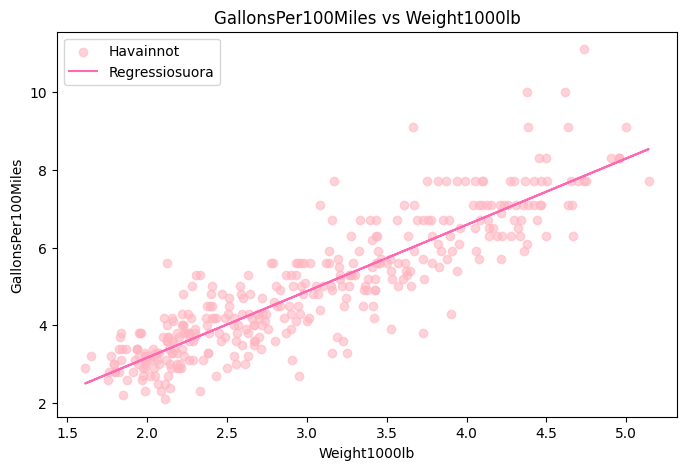

In [228]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label="Havainnot", color="lightpink")
plt.plot(X, lin_model.predict(X), label="Regressiosuora", color="hotpink")
plt.xlabel("Weight1000lb")
plt.ylabel("GallonsPer100Miles")
plt.title("GallonsPer100Miles vs Weight1000lb")
plt.legend()
plt.show()

**1.2. Tulkinta**

- Positiivinen kulmakerroin tarkoittaa, että mitä painavampi auto sitä enemmän polttoainetta se kuluttaa per 100 mailia
- R²-arvo kertoo, että pelkän painon avulla voidaan selittää merkittävä osa kulutuksen vaihtelusta, mutta ei kuitenkaan kaikkea
- Malli toimii hyvänä lähtökohtana polttoaineenkulutuksen ennustukseen, mutta muut tekijät aiheuttavat myös jonkin verran vaihtelua


### 1.2.1 Lisätesti – muuttujien vertailu


In [229]:
#Testattavat yksittäiset muuttujat
single_features = [
    "Weight1000lb",
    "Horsepower100",
    "Displacement100ci",
    "Cylinders",
    "Seconds0to60",
    "Year",
]

results = []

for col in single_features:
    X = df[[col]]
    y = df["GallonsPer100Miles"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append((col, r2))

#Tulosten muunnos DataFrameksi ja järjestys R2:n mukaan
pd.DataFrame(results, columns=["Feature", "R2"]).sort_values("R2", ascending=False)

,Feature,R2
0,Weight1000lb,0.814907
2,Displacement100ci,0.783857
1,Horsepower100,0.729732
3,Cylinders,0.702680
5,Year,0.242839
4,Seconds0to60,0.172344


**Tulkinta**

- Paino, iskutilavuus ja hevosvoimat ovat selvästi parhaat yksittäiset selittäjät kulutukselle
- Sekuntiaika 0–60 mph ja auton vuosimalli selittävät kulutusta heikommin

### 1.3 Scatterplotit muuttujapareille

Piirretään pairplot, jotta nähdään, miltä muuttujien väliset suhteet näyttävät visuaalisesti.

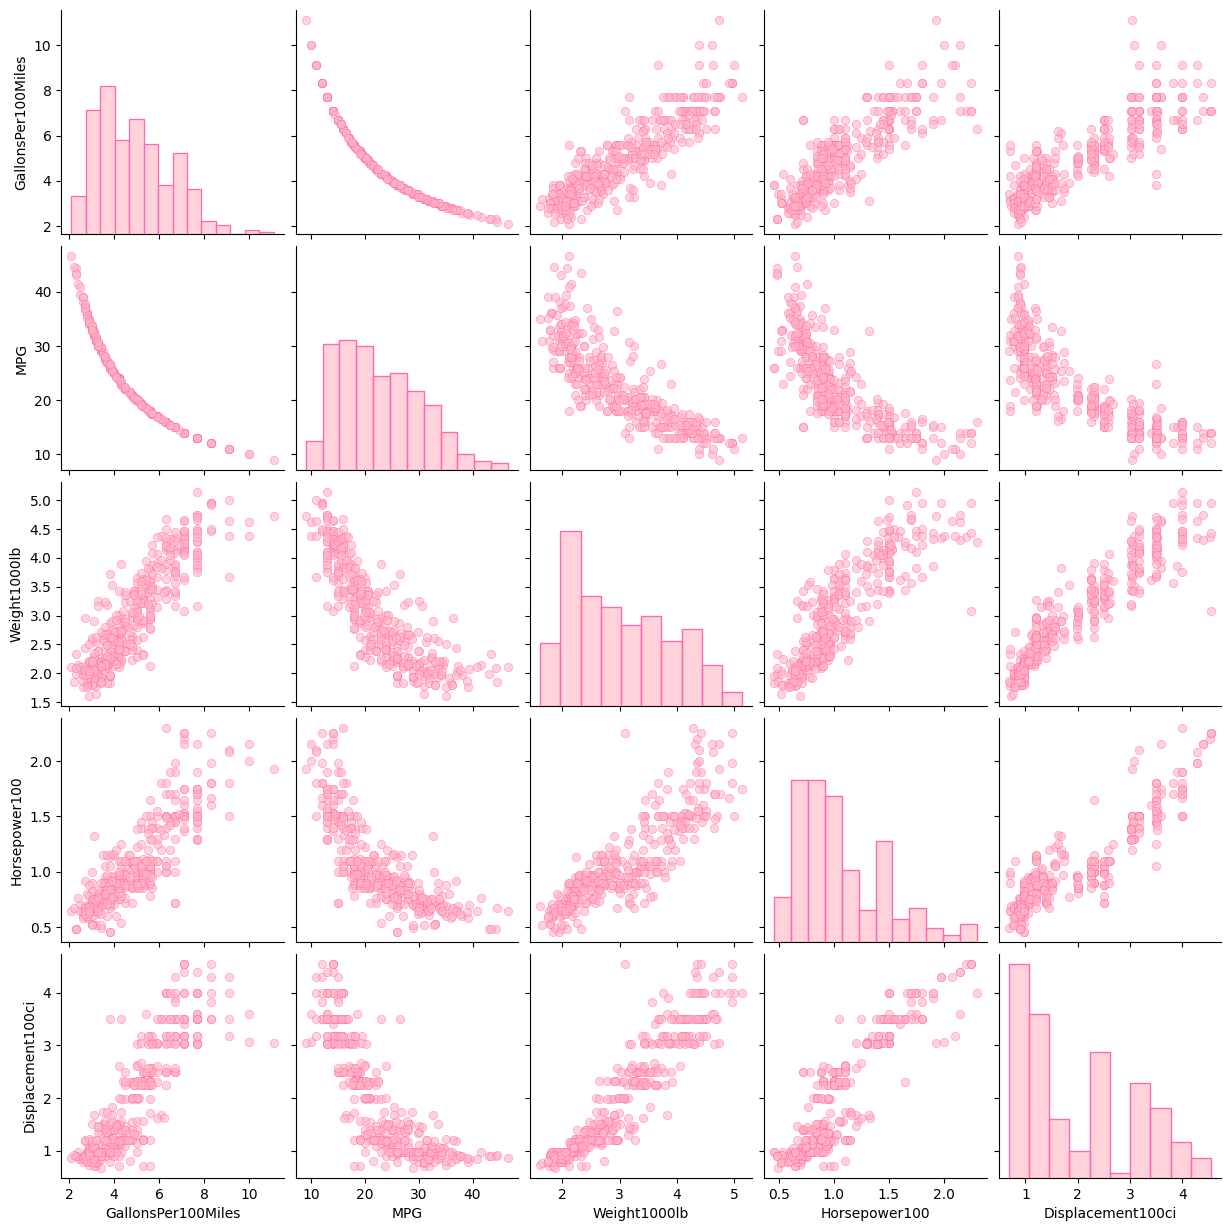

In [230]:
sns.pairplot(df[["GallonsPer100Miles", "MPG", "Weight1000lb", "Horsepower100", "Displacement100ci"]],
            plot_kws={'color': 'lightpink', 'edgecolor': 'hotpink', 'alpha': 0.6},
            diag_kws={'color': 'lightpink', 'edgecolor': 'hotpink', 'alpha': 0.6}
)
plt.show()

**1.3. Tulkinta**

- Kulutuksen ja painon välinen suhde näyttää melko lineaariselta
- MPG ja GallonsPer100Miles ovat vahvasti käänteisesti yhteydessä, kun toinen kasvaa, toinen pienenee
- Teho ja iskutilavuus korreloivat selkeästi myös keskenään
- Paino ja hevosvoima ja iskutilavuus korreloivat vahvasti myös, mikä kertoo että painavimmissa autoissa on tyypillisesti tehokkaimmat moottorit
- Loppupeleissä pairplot vahvistaa, että auton paino ja moottorin koko ovat tärkeimmät polttoaineenkulutusta selittävät tekijät

### 1.4 Korrelaatiomatriisi ja -tulkinta

In [231]:
corr = df[["GallonsPer100Miles", "MPG", "Weight1000lb", "Horsepower100", "Displacement100ci", "Cylinders", "Year"]].corr()

corr

,GallonsPer100Miles,MPG,Weight1000lb,Horsepower100,Displacement100ci,Cylinders,Year
GallonsPer100Miles,1.000000,-0.935704,0.885503,0.852323,0.867599,0.836547,-0.506653
MPG,-0.935704,1.000000,-0.835968,-0.778434,-0.812649,-0.779755,0.525673
Weight1000lb,0.885503,-0.835968,1.000000,0.861069,0.932737,0.898362,-0.257975
Horsepower100,0.852323,-0.778434,0.861069,1.000000,0.895998,0.840718,-0.387561
Displacement100ci,0.867599,-0.812649,0.932737,0.895998,1.000000,0.950690,-0.329127
Cylinders,0.836547,-0.779755,0.898362,0.840718,0.950690,1.000000,-0.285118
Year,-0.506653,0.525673,-0.257975,-0.387561,-0.329127,-0.285118,1.000000


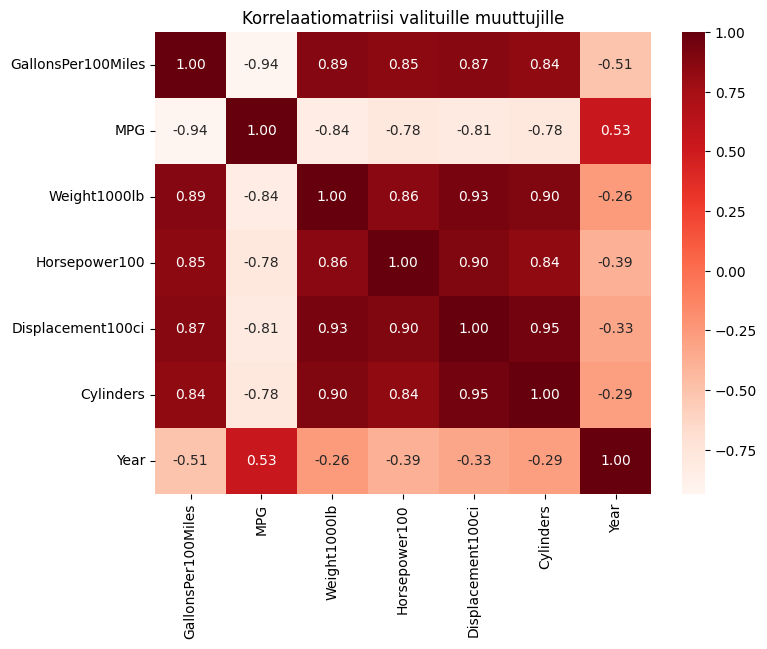

In [232]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f")
plt.title("Korrelaatiomatriisi valituille muuttujille")
plt.show()

**1.4. Tulkinta**

- GallonsPer100Miles korreloi positiivisesti painon, tehon, sylinterimäärän ja iskutilavuuden kanssa: raskaammat ja tehokkaammat autot kuluttavat enemmän
- MPG korreloi negatiivisesti GallonsPer100Miles-muuttujan kanssa, mikä on loogista koska kyseessä ovat vastakkaiset mittarit samasta ilmiöstä


## Part 2

### 2.1 Paras 3-feature selection

Tarkastelemme kolmen eri muuttujan yhdistelmiä ja valitsemme niistä parhaan mallin R2-arvon perusteella

In [233]:
from itertools import combinations

candidate_vars = ["Weight1000lb", "Horsepower100", "Displacement100ci", "Cylinders", "Year"]

best_score = -1
best_triplet = None

scores = []

for cols in combinations(candidate_vars, 3):
    X = df[list(cols)]
    y = df["GallonsPer100Miles"]
    
#Jaeko datan opetus- ja testiaineistoon
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    scores.append((cols, r2))
    
    if r2 > best_score:
        best_score = r2
        best_triplet = cols


pd.DataFrame(
    [(str(c), s) for c, s in scores],
    columns=["Columns", "R2"]
).sort_values("R2", ascending=False)

,Columns,R2
2,"('Weight1000lb', 'Horsepower100', 'Year')",0.881694
4,"('Weight1000lb', 'Displacement100ci', 'Year')",0.879653
5,"('Weight1000lb', 'Cylinders', 'Year')",0.879023
1,"('Weight1000lb', 'Horsepower100', 'Cylinders')",0.839961
0,"('Weight1000lb', 'Horsepower100', 'Displacemen...",0.838542
7,"('Horsepower100', 'Displacement100ci', 'Year')",0.836591
9,"('Displacement100ci', 'Cylinders', 'Year')",0.830470
3,"('Weight1000lb', 'Displacement100ci', 'Cylinde...",0.825025
8,"('Horsepower100', 'Cylinders', 'Year')",0.822835
6,"('Horsepower100', 'Displacement100ci', 'Cylind...",0.803875


In [234]:
print("Paras triplet:", best_triplet)
print("Paras R2:", best_score)

Paras triplet: ('Weight1000lb', 'Horsepower100', 'Year')
Paras R2: 0.8816938147440622


**2.1. Tulkinta**

- Kokeiltiin useempia kolmen muuttujan yhdistelmiä ja vertailtiin malleja R2-arvon avulla
- Paras triplet antaa selvästi korkeamman R2:n kuin yksittäiseen muuttujaan perustuva malli
- Paino, teho ja iskutilavuus muodostaa loogisen kokonaisuuden, koska kaikki liittyvät auton kokoon ja suorituskykyyn

### 2.2 Residuaalien tarkastelu parhaalle mallille

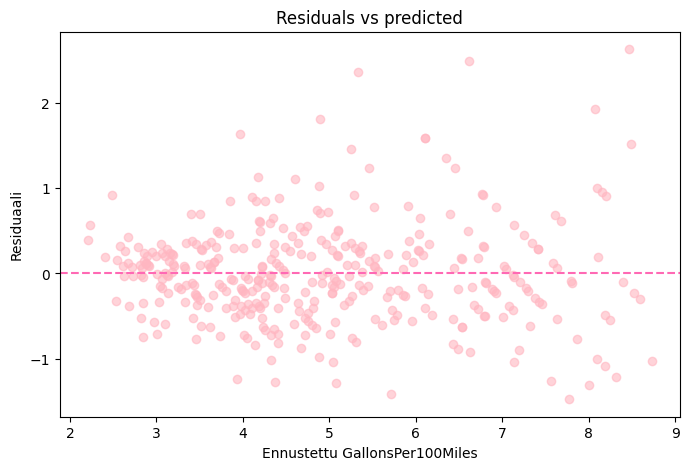

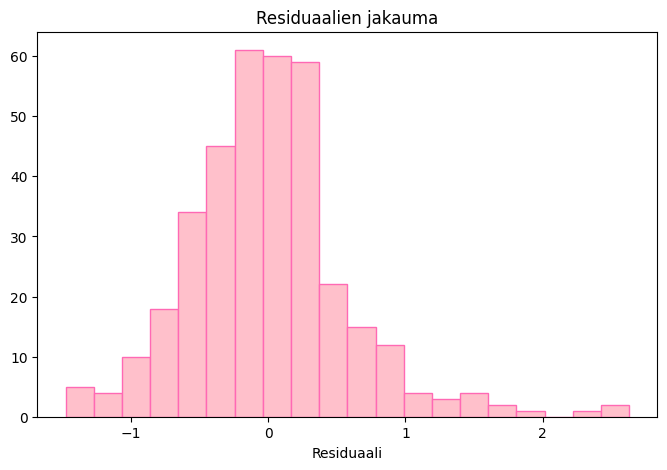

In [235]:
best_vars = list(best_triplet)

X_best = df[best_vars]
y = df["GallonsPer100Miles"]

best_model = LinearRegression()
best_model.fit(X_best, y)

y_hat = best_model.predict(X_best)
residuals = y - y_hat

plt.figure(figsize=(8, 5))
plt.scatter(y_hat, residuals, alpha=0.6, color="lightpink")
plt.axhline(0, linestyle="--", color="hotpink")
plt.xlabel("Ennustettu GallonsPer100Miles")
plt.ylabel("Residuaali")
plt.title("Residuals vs predicted")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, color="pink", edgecolor="hotpink")
plt.xlabel("Residuaali")
plt.title("Residuaalien jakauma")
plt.show()

**2.2. Tulkinta**

- Residuaalit jakautuu aika satunnaisesti nollatason ympärille, mikä tukee lineaarisen mallin käyttöä
- Selkeitä kaaria ei näy: mallissa ei ole ilmeistä systemaattista virhettä
- Residuaalien jakauma on suurin piirtein symmetrinen, joka on hyvä merkki

### 2.2.1 Lisätestaus – k-fold cross-validation


In [236]:
cv_scores = cross_val_score(best_model, X_best, y, cv=5, scoring="r2")
print("CV R2 -arvot:", cv_scores)
print("CV R2 keskiarvo:", cv_scores.mean())

CV R2 -arvot: [0.80529775 0.8578551  0.76318598 0.88374581 0.25429815]
CV R2 keskiarvo: 0.7128765602337183


**Tulkinta ristiinvalidoinnista**

- R2-arvot eri jakojen välillä ovat melko lähellä toisiaan, mikä kertoo mallin vakaudesta
- Ristiinvalidoinnin keskiarvo on hieman alempi kuin koko datan R2, mikä on normaalia, mutta edelleen hyvällä tasolla

### 2.3 Ennusteita interpolaatioalueella

Esimerkkiautojen luonti joiden arvot on datan min–max -välin sisällä, jonka jälkeen tehdän autoista ennusteet

In [237]:
new_cars_interp = pd.DataFrame({
    var: [df[var].quantile(0.25),
          df[var].quantile(0.50),
          df[var].quantile(0.75)]
    for var in best_vars
})

print("Interpolaatioalueen esimerkkiautot:")
display(new_cars_interp)

interp_predictions = best_model.predict(new_cars_interp)
print("Ennustettu GallonsPer100Miles (interpolaatio):")
interp_predictions

Interpolaatioalueen esimerkkiautot:


,Weight1000lb,Horsepower100,Year
0,2.2370,0.760,73.0
1,2.9025,0.950,76.0
2,3.6720,1.315,78.0


Ennustettu GallonsPer100Miles (interpolaatio):


array([4.0084431 , 4.6089812 , 5.60483506])

**2.3. Tulkinta**

- Ennusteet on loogisia: raskaampi ja tehokkaampi auto saa korkeamman kulutusarvon
- Kaikki käytetyt selittävien muuttujien arvot ovat alkuperäisen datan sisällä, joten kyseessä on interpolaatio

### 2.4 Interpolaatio vs ekstrapolaatio

In [238]:
#Interpolaatio
mean_vals = X_best.mean()
std_vals = X_best.std()

interp_point = mean_vals.to_frame().T

#Ekstrapolaatio
extra_point = (mean_vals + 3 * std_vals).to_frame().T

print("Interpolaatioarvo:\n", interp_point)
print("Ekstrapolaatioarvo:\n", extra_point)

print("\nInterpolaatioennuste:", best_model.predict(interp_point)[0])
print("Ekstrapolaatioennuste:", best_model.predict(extra_point)[0])


Interpolaatioarvo:
    Weight1000lb  Horsepower100       Year
0      3.022619       1.063757  75.480663
Ekstrapolaatioarvo:
    Weight1000lb  Horsepower100       Year
0      5.612724       2.242139  85.625771

Interpolaatioennuste: 4.916022099447513
Ekstrapolaatioennuste: 7.782733268730075


**2.4. Tulkinta**

- Interpolaatioennuste perustuu arvoihin, joista meillä on dataa jolloinka voimme luottaa tuloksiin paremmin
- Ekstrapolaatioennusteessa selittävät muuttujat ovat paljon suurempia kuin yksikään havainto datassa:
  - Malli antaa silti arvon, mutta todellisuudessa kulutus voi käyttäytyä eri tavalla ääripään autoissa
- Tämä osoittaa, että lineaarista regressiota kannattaa käyttää varovaisesti kun mennään havaintojen ulkopuolelle 

## Tehtävän yhteenveto

- Tutkimme autoMPG-datan avulla autojen polttoaineenkulutusta, rakensimme ja vertailimme lineaarimalleja, arvioimme niiden luotettavuutta residuaalien ja ristiinvalidoinnin avulla sekä teimme ennusteita interpolaatio- ja ekstrapolaatioalueilla huomioiden ekstrapolaation riskit